### Imports

In [1]:
import nltk
import numpy as np

### Helper functions

In [2]:
def load_text_file(file_path: str) -> np.ndarray[str]:
    """
    Load a text file and return an array of lines from the file.

    Args:
        file_path: str: The path to the file to load.

    Returns:
        np.ndarray: An array of lines from the file.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return np.array([line.strip() for line in lines])

### Load the text files

In [3]:
train_text_path: str = "../dataset/train_text.txt"
train_label_path: str = "../dataset/train_labels.txt"

test_text_path: str = "../dataset/test_text.txt"
test_label_path: str = "../dataset/test_labels.txt"

validationt_text_path: str = "../dataset/val_text.txt"
validationt_label_path: str = "../dataset/val_labels.txt"

train_text: np.ndarray[str] = load_text_file(train_text_path)
train_label: np.ndarray[str] = load_text_file(train_label_path)

test_text: np.ndarray[str] = load_text_file(test_text_path)
test_label: np.ndarray[str] = load_text_file(test_label_path)

validationt_text: np.ndarray[str] = load_text_file(validationt_text_path)
validationt_label: np.ndarray[str] = load_text_file(validationt_label_path)

## Kelvin's Part

Imports will be moved to the top of this notebook only after the model is accepted

### Preprocessing

In [4]:
import operator
from nltk.sentiment import SentimentIntensityAnalyzer
import sklearn
# Feature selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
# For result
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score

#### Functions

In [5]:
def get_list_tokens(sentence: str) -> list[str]:
    """
    Tokenize a sentence into words.

    Args:
        sentence: a string.

    Returns:
        list: A list of tokenized strings.
    """
    lemmatizer = nltk.stem.WordNetLemmatizer()
    sentence_split: list[str] = nltk.tokenize.sent_tokenize(sentence)
    list_tokens: list[str] = []
    for substring in sentence_split:
        list_tokens_sentence: list[str] = nltk.tokenize.word_tokenize(substring)
        for token in list_tokens_sentence:
            list_tokens.append(lemmatizer.lemmatize(token).lower())
    return list_tokens


def get_vector_text(list_vocab: list[str], input_string: str) -> np.ndarray[float]:
    """
    Generate a vector representation of the input string based on word frequency.

    Args:
        list_vocab: A list of vocabulary words.
        input_string: The input string.

    Returns:
        np.ndarray: A NumPy array of float representing the vectorized text.
    """
    vector_text: np.ndarray = np.zeros(len(list_vocab))
    list_tokens_string: np.ndarray[str] = get_list_tokens(input_string)
    for i, word in enumerate(list_vocab):
        if word in list_tokens_string:
            vector_text[i] = list_tokens_string.count(word)
    return np.array(vector_text)


def get_sentiment(line: str) -> list[float]:
    """
    Get the score of a word based on sentiment analysis from nltk.

    I (Kelvin) am not using the analyzer directly on the sentence because it
    cannot demonstrate our expertise in applied machine learning.
    I have asked the professor and he allowed us to use SentimentIntensityAnalyzer.

    Args:
        line: A sentence.

    Returns:
        list[float]: The compound score of 10 words in the sentence which has
        the most significant score (far from 0). If the sentence has less than
        10 words, the value of the remaining elements will be 0.

        The size of the list is always 10.
    """
    scores: list[float] = []
    analyzer = SentimentIntensityAnalyzer()
    for word in get_list_tokens(line):
        score: dict[str, float] = analyzer.polarity_scores(word)
        scores.append(score["compound"])

    retult: list[float] = [0.0] * 10

    # Get the 10 most significant scores
    top_10: list[float] = sorted(scores, key=lambda x: abs(x), reverse=True)[:10]

    # Add 0.0 if the length is less than 10
    top_10 += [0.0] * (10 - len(top_10))

    return top_10

In [6]:
# Download NLTK resources
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("vader_lexicon", quiet=True)

# Create a set of stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords.update({".", ",", "--", "``", "''", "@", "#", ":", ";"})
stopwords.update({"&", "(", ")", "-"})

In [7]:
# Create dict_word_frequency
# word is the key, count of the word is the value
dict_word_frequency: dict[str, int] = {}
for line in train_text:
    sentence_tokens: list[str] = get_list_tokens(line)
    for word in sentence_tokens:
        if word in stopwords:
            continue
        if word not in dict_word_frequency:
            dict_word_frequency[word] = 1
        else:
            dict_word_frequency[word] += 1

# Get the top 1000 most frequent words
sorted_list: list[tuple[str, int]] = sorted(
    dict_word_frequency.items(), key=operator.itemgetter(1), reverse=True
)[:1000]

# Show the top 25 most frequent words and their counts
i = 0  # Reset i
for word, frequency in sorted_list[:25]:
    i += 1
    print(f"{str(i)}. {word} - {str(frequency)}")

vocabulary: list[str] = [word for word, _ in sorted_list]

1. ! - 16866
2. user - 16855
3. 's - 8444
4. ... - 7467
5. ? - 7240
6. tomorrow - 7201
7. may - 6636
8. day - 4080
9. n't - 3604
10. wa - 3507
11. night - 3044
12. going - 3028
13. see - 2842
14. friday - 2697
15. sunday - 2611
16. 1st - 2609
17. time - 2564
18. like - 2507
19. get - 2477
20. 'm - 2221
21. go - 2138
22. saturday - 2101
23. amp - 2013
24. game - 1960
25. one - 1960


In [8]:
x_train = []
y_train = []

for i, line in enumerate(train_text):
    # Feature 1: Word frequency
    vector_pos: np.ndarray[float] = get_vector_text(vocabulary, line)
    # Feature 2: Score from SentimentIntensityAnalyzer by nltk
    # This takes around 4 min on my PC (i5-12400)
    score: np.ndarray[float] = np.array(get_sentiment(line))
    x_train.append(np.concatenate((score, vector_pos)))
    y_train.append(float(train_label[i]))

x_train: np.ndarray[np.ndarray[np.float64]] = np.asarray(x_train)
y_train: np.ndarray[np.float64] = np.asarray(y_train)

# Feature selection
feature_selection = SelectKBest(k=500).fit(x_train, y_train)

# Keep for later use, to select the same index on the test set
selected_indices = feature_selection.get_support(indices=True)
x_train = x_train[:, selected_indices]

In [9]:
# Do the same processing on the test set
x_test = []
y_test = []

for i, line in enumerate(test_text):
    # Feature 1: Word frequency
    vector_pos: np.ndarray[float] = get_vector_text(vocabulary, line)
    # Feature 2: Score from SentimentIntensityAnalyzer by nltk
    # This takes around 4 min on my PC (i5-12400)
    score: np.ndarray[float] = np.array(get_sentiment(line))
    x_test.append(np.concatenate((score, vector_pos)))
    y_test.append(float(test_label[i]))

x_test: np.ndarray[np.ndarray[np.float64]] = np.asarray(x_test)
y_test: np.ndarray[np.float64] = np.asarray(y_test)

# Use the same index from train set for x_test
x_test = x_test[:, selected_indices]

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [11]:
regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, n_jobs=-1)
regression_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1)

### Result - Logistic Regression

In [12]:
y_pred = regression_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5958971019211983


### K-NN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [14]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_classifier.fit(x_train, y_train)

KNeighborsClassifier(n_jobs=-1)

### Result - K-NN

In [15]:
y_pred = knn_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.523689352002605


### SVM

In [16]:
from joblib import parallel_backend

In [17]:
svm_model = sklearn.svm.SVC(kernel="linear", gamma='auto')
with parallel_backend('threading'):
    svm_model.fit(x_train, y_train)

### Result - SVM

In [18]:
y_pred = svm_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5797785737544774


### Using boosting

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [20]:
adaboost_classifier = AdaBoostClassifier(estimator=None, n_estimators=500, learning_rate=1.0)

adaboost_classifier.fit(x_train, y_train)
y_pred = adaboost_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

C:\Users\Kelvin\anaconda3\envs\CU_ML_A2\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.6085965483555845


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


gradient_boosting_classifier= GradientBoostingClassifier(n_estimators=1000, verbose=1)
gradient_boosting_classifier.fit(x_train, y_train)
y_pred = gradient_boosting_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

      Iter       Train Loss   Remaining Time 
         1           0.9848            9.87m
         2           0.9607            9.85m
         3           0.9414            9.83m
         4           0.9258            9.79m
         5           0.9128            9.78m
         6           0.9020            9.80m
         7           0.8929            9.80m
         8           0.8853            9.80m
         9           0.8784            9.77m
        10           0.8727            9.75m
        20           0.8389            9.57m
        30           0.8229            9.37m
        40           0.8127            9.18m
        50           0.8048            9.01m
        60           0.7984            8.86m
        70           0.7926            8.72m
        80           0.7877            8.59m
        90           0.7832            8.47m
       100           0.7789            8.35m
       200           0.7478            7.33m
       300           0.7266            6.38m
       40

### CNN (Try)

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.regularizers import l2

In [25]:
# Process the validationt set like the test set
x_validation = []
y_validation = []

for i, line in enumerate(validationt_text):
    # Feature 1: Word frequency
    vector_pos: np.ndarray[float] = get_vector_text(vocabulary, line)
    # Feature 2: Score from SentimentIntensityAnalyzer by nltk
    # This takes around 4 min on my PC (i5-12400)
    score: np.ndarray[float] = np.array(get_sentiment(line))
    x_validation.append(np.concatenate((score, vector_pos)))
    y_validation.append(float(validationt_label[i]))

x_validation: np.ndarray[np.ndarray[np.float64]] = np.asarray(x_validation)
y_validation: np.ndarray[np.float64] = np.asarray(y_validation)

# Use the same index from train set for x_validationt
x_validation = x_validation[:, selected_indices]

In [26]:
# Find number of unique input
array_count = x_train.flatten()
unique_values = np.unique(array_count)
num_unique_values = len(unique_values)

In [28]:
from sklearn.preprocessing import LabelBinarizer

# For fitting into the CNN
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_validation_one_hot = label_binarizer.transform(y_validation)
y_test_one_hot = label_binarizer.transform(y_test)

In [30]:
# Define CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_unique_values, output_dim=100, input_shape=x_validation[0].shape))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=5))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(3, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(x_validation, y_validation_one_hot))

Epoch 1/10


C:\Users\Kelvin\anaconda3\envs\CU_ML_A2\lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1426/1426 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.5530 - loss: 1.0319 - val_accuracy: 0.6035 - val_loss: 0.8623
Epoch 2/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.6169 - loss: 0.8444 - val_accuracy: 0.6130 - val_loss: 0.8475
Epoch 3/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.6440 - loss: 0.7937 - val_accuracy: 0.6160 - val_loss: 0.8359
Epoch 4/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.6581 - loss: 0.7708 - val_accuracy: 0.6105 - val_loss: 0.8413
Epoch 5/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.6752 - loss: 0.7381 - val_accuracy: 0.6125 - val_loss: 0.8497
Epoch 6/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.6897 - loss: 0.7093 - val_accuracy: 0.6085 - val_loss: 0.8550
Epoch 7/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.7027 - loss: 0.6823 - val_accuracy: 0.6105 - val_loss: 0.8828
Epoch 8/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.7144 - loss: 0.66

In [31]:
# Measure accuracy on test data
loss, accuracy = cnn_model.evaluate(x_test, y_test_one_hot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5161 - loss: 1.1737
Test Loss: 1.1785982847213745
Test Accuracy: 0.5196189880371094


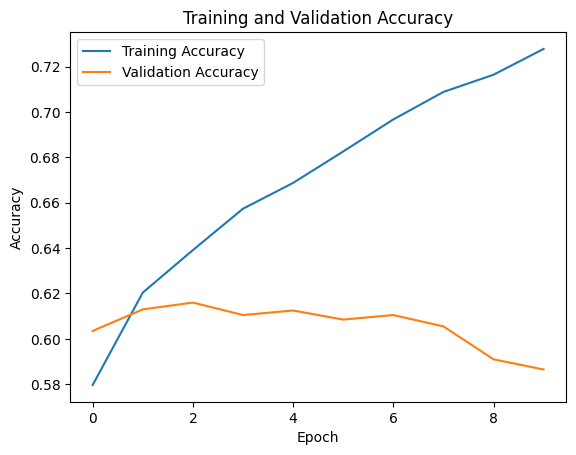

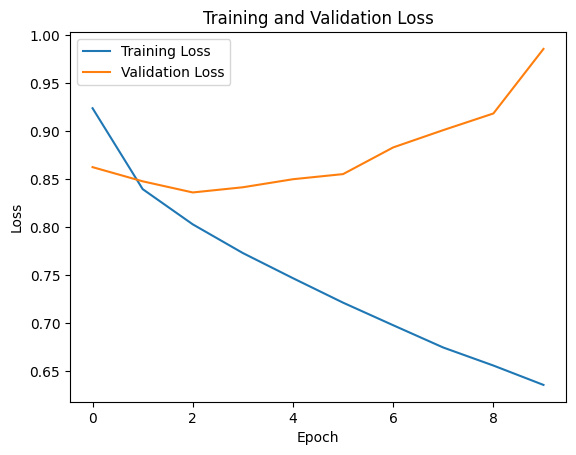

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## [Name]'s Part

your markdown here